In [12]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_state_city
import matplotlib.pyplot as plt
# Loading your IBM Q account(s)
IBMQ.load_accounts()
import numpy as np

In [13]:
def real_map(value, leftMin, leftMax, rightMin, rightMax):
    # Maps one range to another
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [10]:
def QRandom(a, b, qubits=2):
    # Quantum Random Number generator
    q = QuantumRegister(qubits, 'q')
    circ = QuantumCircuit(q)
    c0 = ClassicalRegister(2, 'c0')
    circ.add_register(c0)

    for i in range(qubits):
        circ.h(q[i])


    for i in range(qubits):
        circ.measure(q[i], c0)

    #circ.draw(output='mpl')


    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    #print(job.status())
    result = job.result()
    output = result.get_statevector(circ, decimals=5)

    n1 = 0
    n2 = 0
    n3 = 0
    for i in range( output.size ):
        if abs(output[i]) != 0:
            #print(i, output[i])
            n1 = i
            n2 = np.real(output[i])
            n3 = np.imag(output[i])
    
    y = real_map(n1+n2+n3, -qubits, len(output)-1+qubits, a, b) 
    plot_state_city(output)
    return y

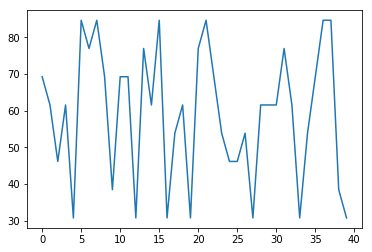

In [14]:
x = []
for i in range(40):
    x.append( QRandom(0, 100,3) )

plt.plot(x)